In [116]:
import pandas as pd
import numpy as np
import re
import csv

FILE = "H:\\folder\\Day_2\\CarsDatasets2025.csv"


# ---------- 1) Robust read ----------
def read_csv(path):
    # try utf-8; fall back to latin1/cp1252; use Python engine for odd rows
    encodings = ["utf-8", "latin1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(
                path,
                encoding=enc,
                engine="python",
                skip_blank_lines=True,
                on_bad_lines="skip",            # skip lines with wildly wrong comma counts
                quoting=csv.QUOTE_MINIMAL,
                skipinitialspace=True
            )

            return df
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv(FILE)

'''
Key parameters & options (what they mean + good defaults)

encoding: character set for decoding bytes → text.
Common: "utf-8" (best), "latin1"/"cp1252" (Windows/Excel exports).

engine:
"c" (default): fastest, stricter; may choke on malformed rows.
"python": slower, tolerant to odd quoting/comma mismatches.

on_bad_lines (pandas ≥ 1.3):
"error" (default): raise on malformed lines.
"warn": log a warning, skip line (older pandas).
"skip": silently skip bad lines (your choice).

quoting:
csv.QUOTE_MINIMAL (default): quote only when needed.
csv.QUOTE_ALL: quote all fields (useful when writing).
skipinitialspace=True: trims spaces immediately after delimiters.

Other useful knobs you might add later:
sep=";" (non-comma delimiters)
thousands="," (parse numbers with thousands separators)
dtype={...} (enforce column dtypes)
usecols=[...] (load subset of columns)
na_values=[...] (custom missing markers)
low_memory=False (more accurate type inference, higher memory)
memory_map=True (faster IO on large files)
nrows=... (read a sample for schema detection)
'''

'\nKey parameters & options (what they mean + good defaults)\n\nencoding: character set for decoding bytes → text.\nCommon: "utf-8" (best), "latin1"/"cp1252" (Windows/Excel exports).\n\nengine:\n"c" (default): fastest, stricter; may choke on malformed rows.\n"python": slower, tolerant to odd quoting/comma mismatches.\n\non_bad_lines (pandas ≥ 1.3):\n"error" (default): raise on malformed lines.\n"warn": log a warning, skip line (older pandas).\n"skip": silently skip bad lines (your choice).\n\nquoting:\ncsv.QUOTE_MINIMAL (default): quote only when needed.\ncsv.QUOTE_ALL: quote all fields (useful when writing).\nskipinitialspace=True: trims spaces immediately after delimiters.\n\nOther useful knobs you might add later:\nsep=";" (non-comma delimiters)\nthousands="," (parse numbers with thousands separators)\ndtype={...} (enforce column dtypes)\nusecols=[...] (load subset of columns)\nna_values=[...] (custom missing markers)\nlow_memory=False (more accurate type inference, higher memory)\n

In [117]:
# ---------- 2) Header normalization ----------
def normalize_cols(cols):
    out = []
    for c in cols:
        c = str(c)                  # ensure string
        c = c.strip()                 # trim leading/trailing spaces
        c = c.replace("\xa0", " ")                 # replace non-breaking space (common in Excel exports)
        c = re.sub(r"\s+", "_", c)                 # replace any whitespace (space, tab) with underscore
        c = c.replace("/", "_").replace("(", "_").replace(")", "_").replace("-", "_")# map common symbols to underscores
        c = re.sub(r"__+", "_", c)                 # collapse multiple underscores to one
        c = re.sub(r"[^0-9a-zA-Z_]", "", c)        # strip anything that’s not alphanumeric or underscore
        c = c.strip("_")                 # remove underscores at start/end
        out.append(c)                 
    return out

df.columns = normalize_cols(df.columns)

# Quick peek
print(df.shape)
df.head(3)

'''
3) Why we use this

Code safety: messy headers break attribute access (df.Car Name ❌, df.Car_Name ✅).
Consistency: avoids duplicate headers like "Price " vs "Price".
Portability: ensures headers are valid Python identifiers if you later export to SQL/Parquet/JSON.
Ease of regex/plotting: many tools hate special chars in column names.
'''


(1218, 11)


'\n3) Why we use this\n\nCode safety: messy headers break attribute access (df.Car Name ❌, df.Car_Name ✅).\nConsistency: avoids duplicate headers like "Price " vs "Price".\nPortability: ensures headers are valid Python identifiers if you later export to SQL/Parquet/JSON.\nEase of regex/plotting: many tools hate special chars in column names.\n'

In [118]:
# ---------- 3) Helpers to clean numbers ----------
def to_number(x):
    """Extract numbers from messy strings. Handles commas, currency, units,
    and ranges like '12,000—15,000' (averages)."""
    if pd.isna(x): 
        return np.nan
    s = str(x)
    s = s.replace("\xa0", " ")                     # non breaking space removal
    s = s.replace(",", "")                         #remove excess commas
    s = s.replace("—", "-").replace("–", "-")      # normalize dashes
    # remove obvious text tokens
    s = re.sub(r"(km/h|sec|hp|Nm|cc|batt|battery|KM/H|Math input error)", "", s, flags=re.I)
    # keep digits, dot, sign, dash
    nums = re.findall(r"[-+]?\d*\.?\d+", s)
    if not nums:
        return np.nan
    vals = [float(n) for n in nums]
    return float(np.mean(vals))  # average if it's a range

def clean_torque(x):
    return to_number(x)

def clean_price(x):
    # remove currency symbols then reuse to_number (handles ranges)
    if pd.isna(x): 
        return np.nan
    s = str(x).replace("$", "").replace("₹", "").replace("€", "").replace("£","")
    return to_number(s)

def first_number(x):
    """Grab the first meaningful number (useful for CC/Battery_Capacity)."""
    if pd.isna(x): 
        return np.nan
    s = str(x).replace(",", "")
    m = re.search(r"\d*\.?\d+", s)
    return float(m.group()) if m else np.nan



In [119]:
# ---------- 4) Column-specific cleaning ----------
# rename likely columns to predictable names if present
rename_map = {
    "Cars_Prices": "price",
    "Cars_PricesKMH": "price",   # just in case header mangled
    "Performance0___100__KMH": "perf_0_100_s",
    "Performance0__100__KMH": "perf_0_100_s",
    "Performance0__100__": "perf_0_100_s",
    "Performance0___100_": "perf_0_100_s",
    "Total_Speed": "top_speed_kmh",
    "HorsePower": "horsepower",
    "Seats": "seats",
    "Torque": "torque_nm",
    "CC_Battery_Capacity": "cc_capacity",
    "CCBattery_Capacity": "cc_capacity",
}
df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

# Clean numeric-ish columns if they exist
if "horsepower" in df:
    df["horsepower"] = df["horsepower"].apply(to_number)

if "top_speed_kmh" in df:
    df["top_speed_kmh"] = df["top_speed_kmh"].apply(to_number)

# Handle multiple performance header variants
perf_cols = [c for c in df.columns if c.lower().startswith("performance")]
for c in perf_cols:
    df[c] = df[c].apply(to_number)
    df = df.rename(columns={c: "perf_0_100_s"})  # unify name to one column
# If multiple perf columns ended up the same name, keep first non-null
if "perf_0_100_s" in df:
    if isinstance(df["perf_0_100_s"], pd.core.series.Series):
        pass

if "price" in df:
    df["price"] = df["price"].apply(clean_price)

'''
Removes ₹/$/€/£, commas, ranges.
Example: "₹25,00,000–₹30,00,000" → 2750000.0.
'''

if "torque_nm" in df:
    df["torque_nm"] = df["torque_nm"].apply(clean_torque)

'''
Ensures torque is numeric (320 Nm → 320.0).
'''

if "seats" in df:
    df["seats"] = pd.to_numeric(df["seats"], errors="coerce")

'''
Converts string seats ("5" or "5-seater") → 5.
errors="coerce" → invalid values become NaN.
'''

if "cc_capacity" in df:
    df["cc_capacity"] = df["cc_capacity"].apply(first_number)

'''
Extracts first number only.
"1497 cc (1.5L)" → 1497.
"5000–5500 mAh" → 5000.
'''

'\nExtracts first number only.\n"1497 cc (1.5L)" → 1497.\n"5000–5500 mAh" → 5000.\n'

In [120]:
# ---------- 5) Trim whitespace in object columns ----------
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})
# dictionary

'''
df.select_dtypes(include="object").columns
* Selects all columns with dtype "object" (usually strings / categorical text).

astype(str)
Forces every value into a string (even NaN becomes "nan").
* Prevents crashes if some cells are numbers but the column is mixed-type.

.str.strip()
Removes leading/trailing whitespace.
Example: " Petrol " → "Petrol".
Avoids treating "Diesel" and "Diesel " as two categories.

.replace({"nan": np.nan})
Converts the literal string "nan" (from astype(str)) back into a proper np.nan.
* Ensures missing values are consistently recognized as NaN (which pandas/numpy understand).
'''

'\ndf.select_dtypes(include="object").columns\n* Selects all columns with dtype "object" (usually strings / categorical text).\n\nastype(str)\nForces every value into a string (even NaN becomes "nan").\n* Prevents crashes if some cells are numbers but the column is mixed-type.\n\n.str.strip()\nRemoves leading/trailing whitespace.\nExample: " Petrol " → "Petrol".\nAvoids treating "Diesel" and "Diesel " as two categories.\n\n.replace({"nan": np.nan})\nConverts the literal string "nan" (from astype(str)) back into a proper np.nan.\n* Ensures missing values are consistently recognized as NaN (which pandas/numpy understand).\n'

In [121]:
# ---------- 6) Basic sanity filters (optional) ----------
# Remove rows that are clearly broken after parsing (e.g., no car name & no company)
key_text_cols = [c for c in ["Company_Names", "Cars_Names", "CompanyNames", "CarsNames"] if c in df.columns]
if key_text_cols:
    keep_mask = np.zeros(len(df), dtype=bool)
    #np.zeros(len(df), dtype=bool) → start with all False (assume all rows are bad).
    for c in key_text_cols:
        keep_mask |= df[c].notna() & (df[c].astype(str).str.len() > 0)
        '''
        df[c].notna() → keep only non-null rows.
        .astype(str).str.len() > 0 → ensure text isn’t just "".
        Combine conditions with &.
        '''
    df = df[keep_mask]



In [122]:
# ---------- 7) Final check & save ----------
print("\nDtypes:\n", df.dtypes)
print("\nSample:\n", df.head(8))
print("\nMissing per column:\n", df.isna().sum())




Dtypes:
 Company_Names     object
Cars_Names        object
Engines           object
cc_capacity      float64
horsepower       float64
top_speed_kmh    float64
perf_0_100_s     float64
price            float64
Fuel_Types        object
seats            float64
torque_nm        float64
dtype: object

Sample:
   Company_Names            Cars_Names      Engines  cc_capacity  horsepower  \
0       FERRARI         SF90 STRADALE           V8       3990.0       963.0   
1   ROLLS ROYCE               PHANTOM          V12       6749.0       563.0   
2          Ford                   KA+  1.2L Petrol       1200.0        -7.5   
3      MERCEDES               GT 63 S           V8       3982.0       630.0   
4          AUDI            AUDI R8 Gt          V10       5204.0       602.0   
5           BMW          Mclaren 720s           V8       3994.0       710.0   
6  ASTON MARTIN            VANTAGE F1           V8       3982.0       656.0   
7       BENTLEY  Continental GT Azure           V8       39

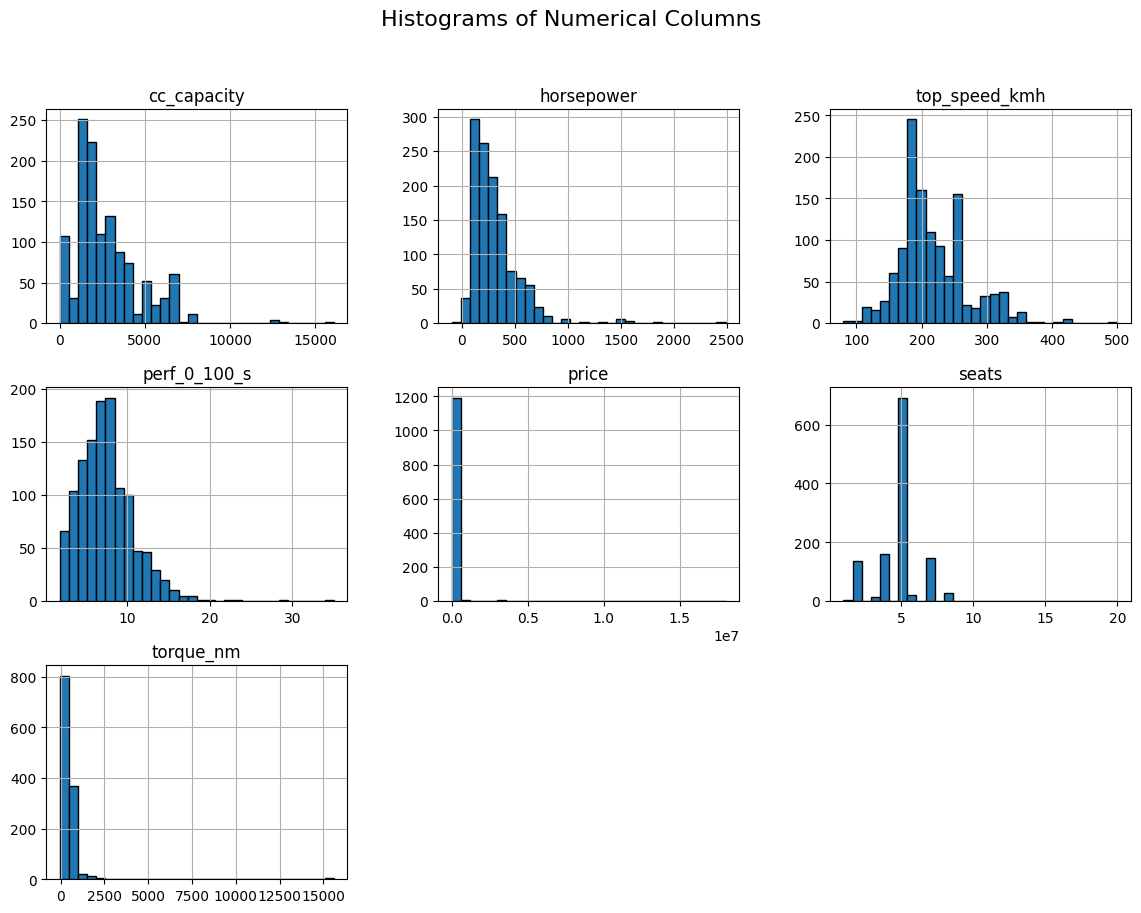

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Histograms ----------
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.show()


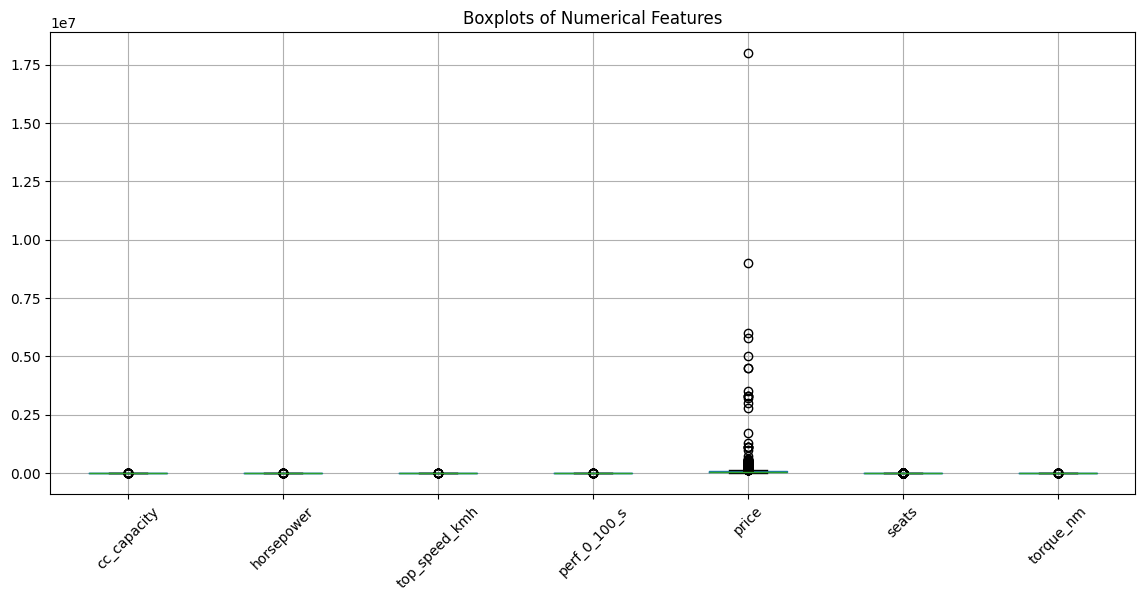

In [124]:

# ---------- Boxplots ----------
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

plt.figure(figsize=(14, 6))
df[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features")
plt.show()



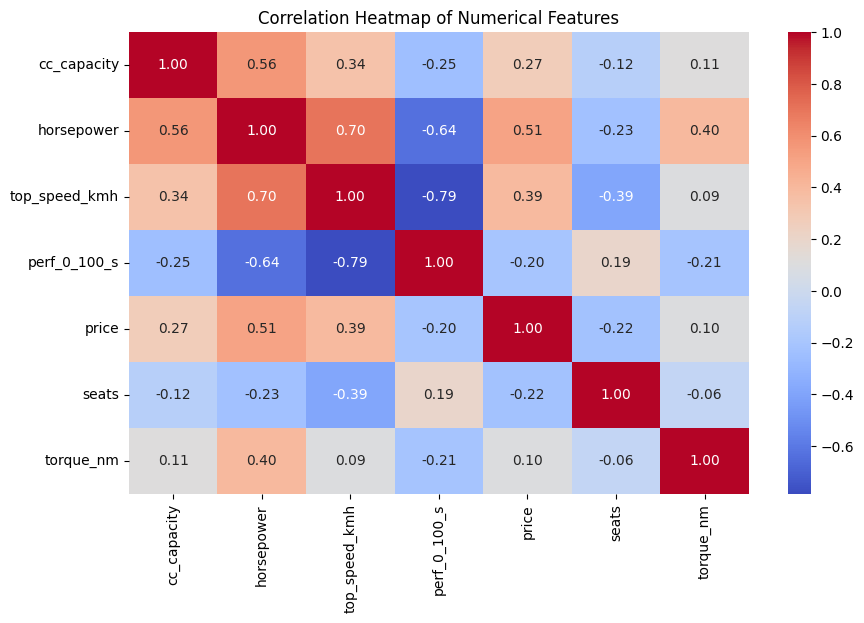

In [125]:
# ---------- Correlation Heatmap ----------
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [126]:
# Count missing values per column
print(df.isna().sum())

# Percentage of missing values
print((df.isna().mean() * 100).round(2))


Company_Names     0
Cars_Names        0
Engines           0
cc_capacity       5
horsepower        0
top_speed_kmh     0
perf_0_100_s      6
price             1
Fuel_Types        0
seats            12
torque_nm         1
dtype: int64
Company_Names    0.00
Cars_Names       0.00
Engines          0.00
cc_capacity      0.41
horsepower       0.00
top_speed_kmh    0.00
perf_0_100_s     0.49
price            0.08
Fuel_Types       0.00
seats            0.99
torque_nm        0.08
dtype: float64


In [127]:
# Drop rows where critical columns are missing
df = df.dropna(subset=["Cars_Names", "Company_Names","cc_capacity","perf_0_100_s","seats"])

# Count missing values per column
print(df.isna().sum())

# Percentage of missing values
print((df.isna().mean() * 100).round(2))

Company_Names    0
Cars_Names       0
Engines          0
cc_capacity      0
horsepower       0
top_speed_kmh    0
perf_0_100_s     0
price            0
Fuel_Types       0
seats            0
torque_nm        0
dtype: int64
Company_Names    0.0
Cars_Names       0.0
Engines          0.0
cc_capacity      0.0
horsepower       0.0
top_speed_kmh    0.0
perf_0_100_s     0.0
price            0.0
Fuel_Types       0.0
seats            0.0
torque_nm        0.0
dtype: float64


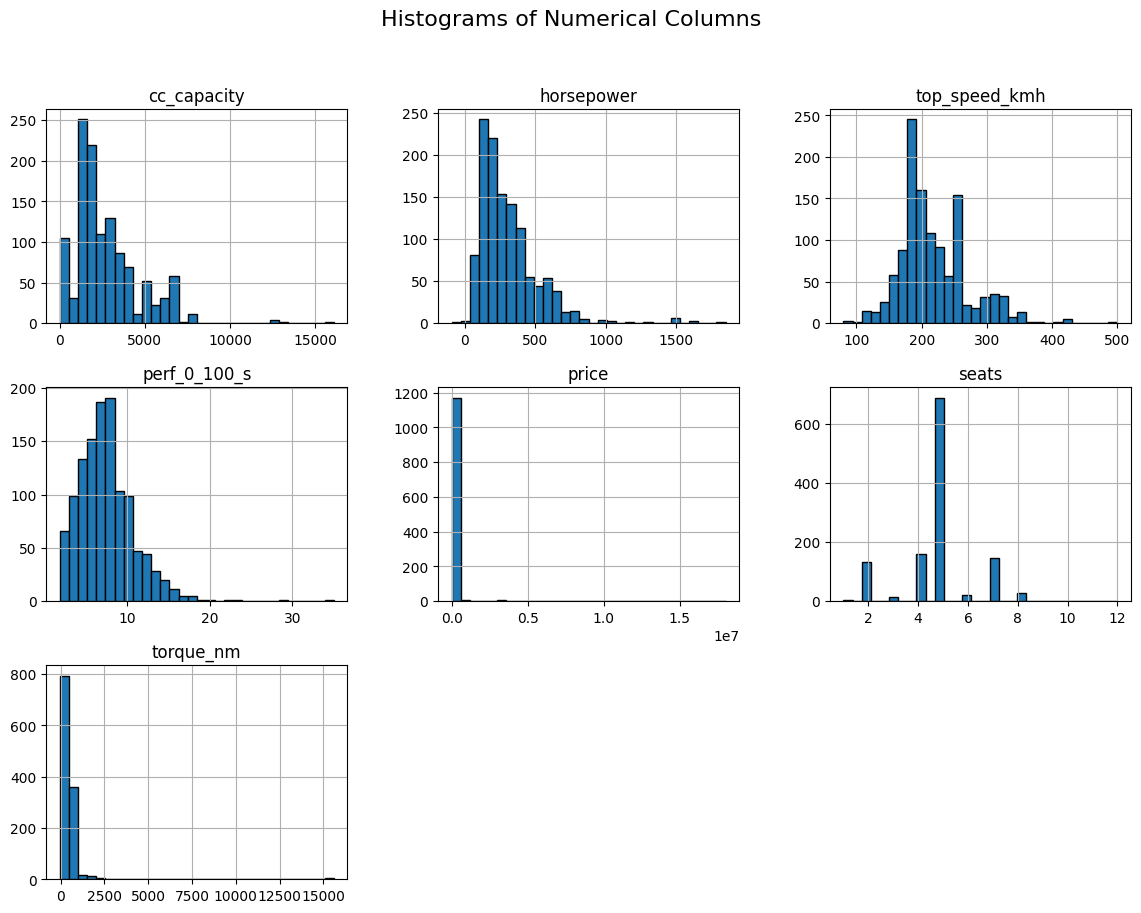

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Histograms ----------
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.show()

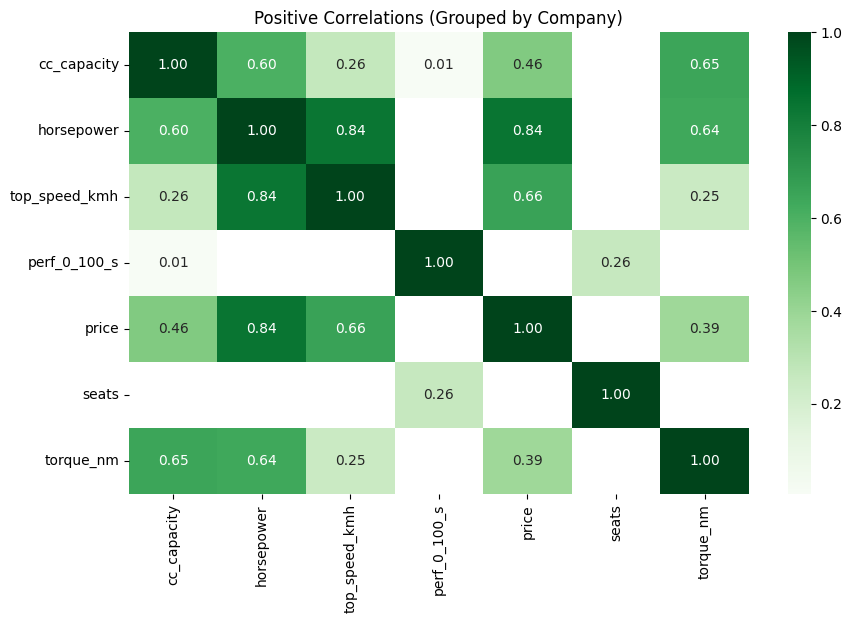

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# group by Company_Names and take mean of numeric cols
grouped = df.groupby("Company_Names").mean(numeric_only=True)

# compute correlation
corr = grouped.corr()

# filter only positive correlations (>0)
pos_corr = corr[corr > 0]

# plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pos_corr, annot=True, cmap="Greens", fmt=".2f")
plt.title("Positive Correlations (Grouped by Company)")
plt.show()


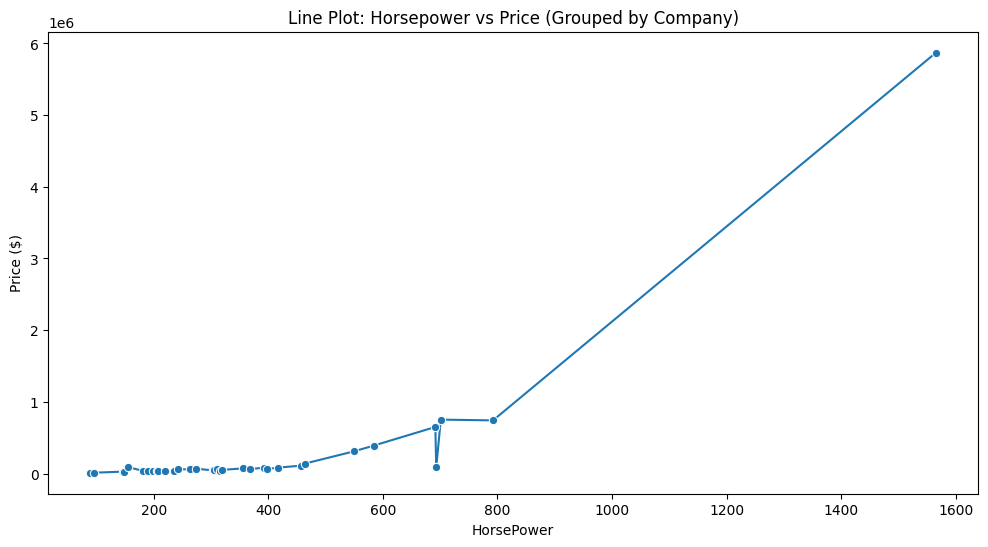

In [130]:
# Example line plot: avg HorsePower vs avg Price per company
plt.figure(figsize=(12,6))
sns.lineplot(data=grouped, x="horsepower", y="price", marker="o")
plt.title("Line Plot: Horsepower vs Price (Grouped by Company)")
plt.xlabel("HorsePower")
plt.ylabel("Price ($)")
plt.show()


In [131]:
df["Fuel_Types_Code"] = df["Fuel_Types"].astype("category").cat.codes
print(df[["Fuel_Types", "Fuel_Types_Code"]].head())


        Fuel_Types  Fuel_Types_Code
0  plug in hyrbrid               20
1           Petrol               12
2           Petrol               12
3           Petrol               12
4           Petrol               12


In [132]:
df["Company_Code"] = df["Company_Names"].astype("category").cat.codes

In [133]:
df


,Company_Names,Cars_Names,Engines,cc_capacity,horsepower,top_speed_kmh,perf_0_100_s,price,Fuel_Types,seats,torque_nm,Fuel_Types_Code,Company_Code
0,FERRARI,SF90 STRADALE,V8,3990.0,963.0,340.0,2.50,1100000.0,plug in hyrbrid,2.0,800.0,20,8
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563.0,250.0,5.30,460000.0,Petrol,5.0,900.0,12,27
2,Ford,KA+,1.2L Petrol,1200.0,-7.5,165.0,10.50,-1500.0,Petrol,5.0,120.0,12,9
3,MERCEDES,GT 63 S,V8,3982.0,630.0,250.0,3.20,161000.0,Petrol,4.0,900.0,12,20
4,AUDI,AUDI R8 Gt,V10,5204.0,602.0,320.0,3.60,253290.0,Petrol,2.0,560.0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487.0,240.0,180.0,7.60,45795.0,Hybrid (Gas + Electric),5.0,239.0,6,31
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393.0,326.0,180.0,6.80,50000.0,Hybrid,7.0,630.0,5,31
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987.0,182.5,190.0,8.60,27172.5,Gas / Hybrid,5.0,200.0,4,31
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,1798.0,169.0,180.0,9.20,33000.0,Hybrid,5.0,197.5,5,31


C:\Users\ASM9016\AppData\Local\Temp\ipykernel_23580\1312939187.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


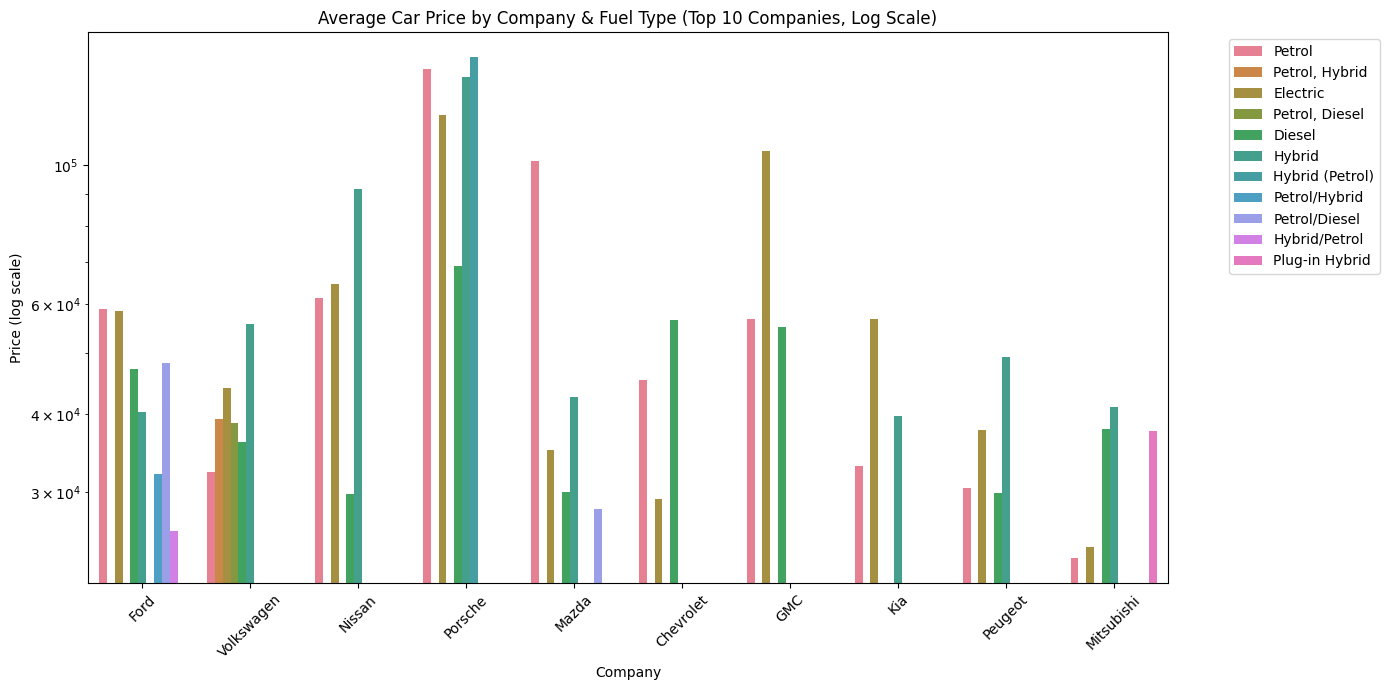

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Take top 10 companies by number of models
top_companies = df["Company_Names"].value_counts().nlargest(10).index
filtered = df[df["Company_Names"].isin(top_companies)]

plt.figure(figsize=(14,7))
sns.barplot(
    data=filtered,
    x="Company_Names",
    y="price",
    hue="Fuel_Types",
    ci=None
)

plt.yscale("log")   # log scale for better visibility
plt.xticks(rotation=45)
plt.title("Average Car Price by Company & Fuel Type (Top 10 Companies, Log Scale)")
plt.ylabel("Price (log scale)")
plt.xlabel("Company")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [135]:
print(df)


     Company_Names         Cars_Names                             Engines  \
0          FERRARI      SF90 STRADALE                                  V8   
1      ROLLS ROYCE            PHANTOM                                 V12   
2             Ford                KA+                         1.2L Petrol   
3         MERCEDES            GT 63 S                                  V8   
4             AUDI         AUDI R8 Gt                                 V10   
...            ...                ...                                 ...   
1213        Toyota       Crown Signia                      2.5L Hybrid I4   
1214        Toyota  4Runner (6th Gen)  2.4L Turbo I4 (i-FORCE MAX Hybrid)   
1215        Toyota      Corolla Cross              2.0L Gas / 2.0L Hybrid   
1216        Toyota              C-HR+                  1.8L / 2.0L Hybrid   
1217        Toyota     RAV4 (6th Gen)        2.5L Hybrid / Plug-in Hybrid   

      cc_capacity  horsepower  top_speed_kmh  perf_0_100_s      price  \
0 

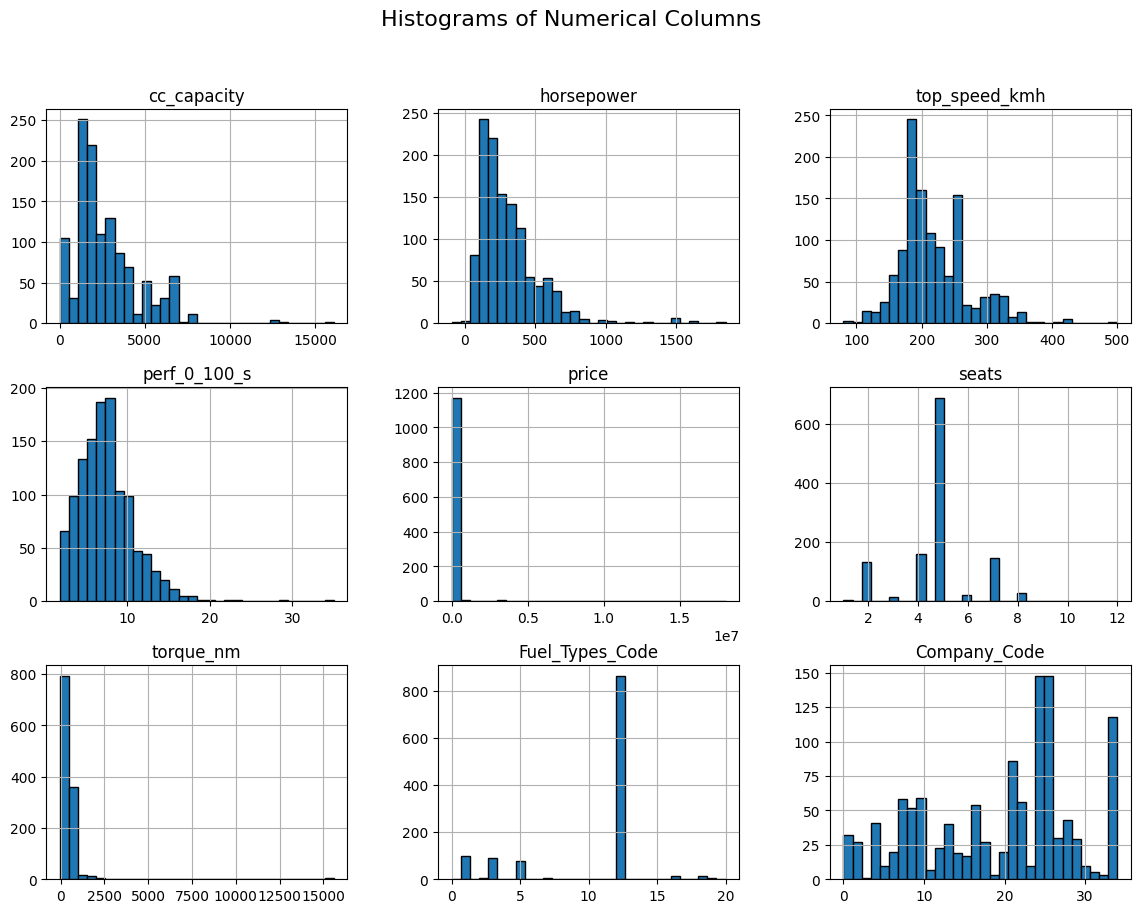

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Histograms ----------
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.show()


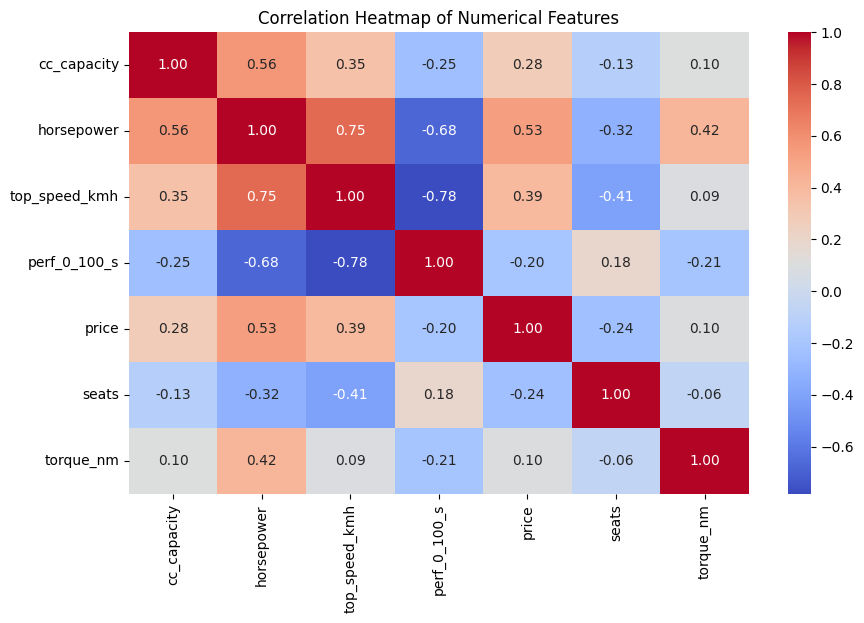

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns
num_df = df.select_dtypes(include=['float64','int64'])

# Compute correlation
corr = num_df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [138]:
#Some rows in your dataset had negative horsepower or negative prices → these break the model.
df = df[(df["horsepower"] > 0) & (df["price"] > 0)]

#Log transformation makes the distribution closer to normal:
y_reg = np.log1p(df["price"])   # log(1 + price) to avoid log(0) issues




In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------- 1. Clean dataset --------
# Remove rows with invalid/negative price or horsepower
df = df[(df["price"] > 0) & (df["horsepower"] > 0)]

# -------- 2. Features & Target --------
# One-hot encode categorical variables
X = pd.get_dummies(df[["cc_capacity", "horsepower", "top_speed_kmh",
                       "perf_0_100_s", "seats", "torque_nm",
                       "Fuel_Types", "Company_Names"]],
                   drop_first=True)

# Log-transform the price target
y = np.log1p(df["price"])   # log(1+price)

# -------- 3. Train/Test Split --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------- 4. Standardize Features --------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------- 5. Linear Regression --------
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

# -------- 6. Evaluation --------
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("🔹 Fine-Tuned Linear Regression")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

# -------- 7. Compare with Ridge & Lasso --------
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
print("Ridge R²:", r2_score(y_test, ridge.predict(X_test_scaled)))

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)
print("Lasso R²:", r2_score(y_test, lasso.predict(X_test_scaled)))


🔹 Fine-Tuned Linear Regression
MSE: 0.09240244058680265
RMSE: 0.30397769751546355
MAE: 0.20352655345061296
R²: 0.8969439726136561
Ridge R²: 0.8972925094365065
Lasso R²: 0.8985750285545024



Logistic Regression Results
Accuracy : 0.8535564853556485
Precision: 0.868421052631579
Recall   : 0.8319327731092437
F1 Score : 0.8497854077253219


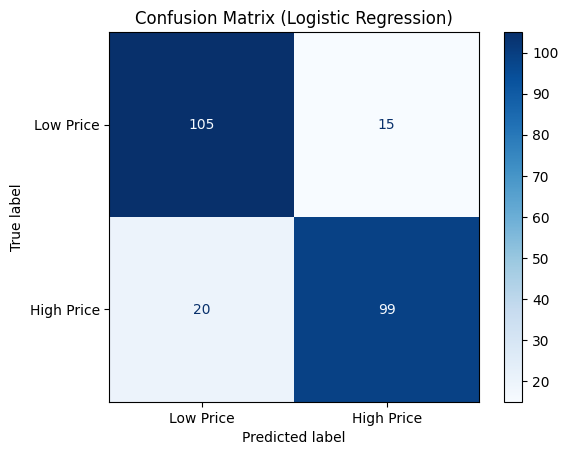

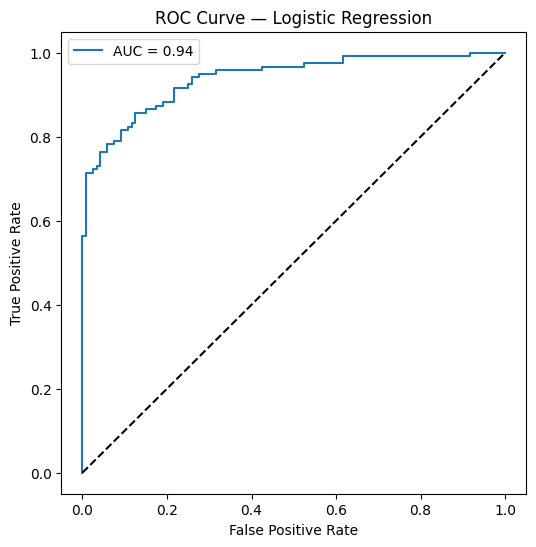

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

# 1) Define features and build a single modeling frame
features = ["cc_capacity","horsepower","top_speed_kmh","perf_0_100_s",
            "seats","torque_nm","Fuel_Types_Code","Company_Code"]

df_model = df[features + ["price"]].dropna()        # drop rows with any NA in X or price
X = df_model[features]
# Binary target: high price vs low price (use median of the same rows!)
y = (df_model["price"] > df_model["price"].median()).astype(int)

# 2) Split once (stratify keeps class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) (Optional) scale numeric features for logistic regression
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 4) Fit & predict
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")  # or 'lbfgs' if no issues
log_reg.fit(X_train_s, y_train)
y_pred = log_reg.predict(X_test_s)
y_proba = log_reg.predict_proba(X_test_s)[:, 1]

# 5) Metrics
print("\nLogistic Regression Results")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Low Price","High Price"]).plot(cmap="Blues")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression"); plt.legend(); plt.show()



Resolved columns:
  target: Cars Prices
  predictors: ['HorsePower', 'Seats']
  ⚠️ Unresolved predictors (not found): ['cc_capacity', 'top_speed_kmh', 'perf_0_100_s', 'torque_nm']
[Parse] HorsePower: numeric 1218/1218 (100.0%)
[Parse] Seats: numeric 1218/1218 (100.0%)
[Parse] Cars Prices: numeric 1217/1218 (99.9%)


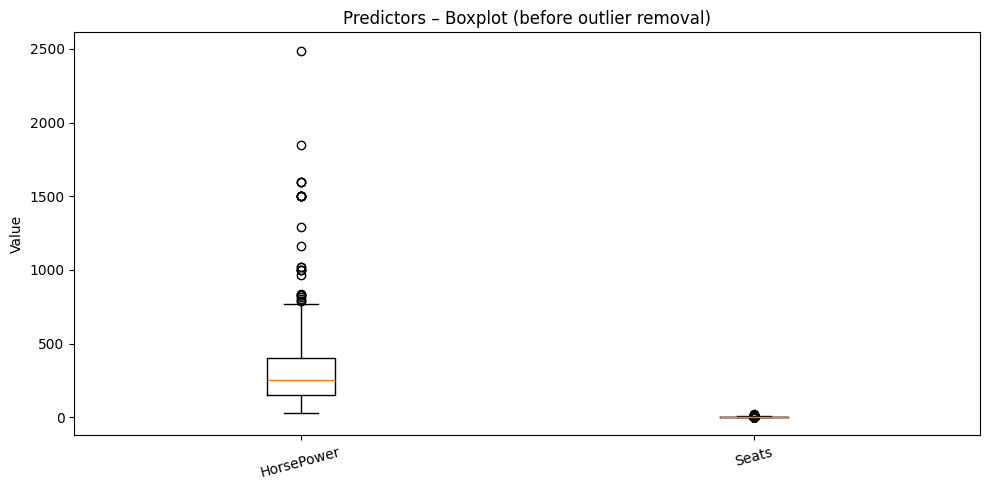


===== Linear Regression: HorsePower vs Cars Prices =====
Outlier detection method: IQR
HorsePower: total=1217, outliers=27, kept=1190
Sample outlier values: [963.0, 789.0, 789.0, 1160.0, 1000.0, 836.0, 819.0, 2488.0, 1020.0, 1020.0]
R²   : 0.176
RMSE : 197259.12
Equation: Cars Prices = -75182.95 + 546.72 * HorsePower


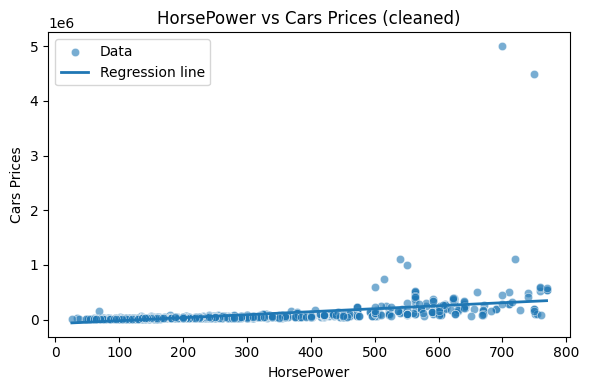


===== Linear Regression: Seats vs Cars Prices =====
Outlier detection method: IQR
Seats: total=1217, outliers=330, kept=887
Sample outlier values: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
R²   : 0.052
RMSE : 80487.89
Equation: Cars Prices = 249731.18 + -39045.72 * Seats


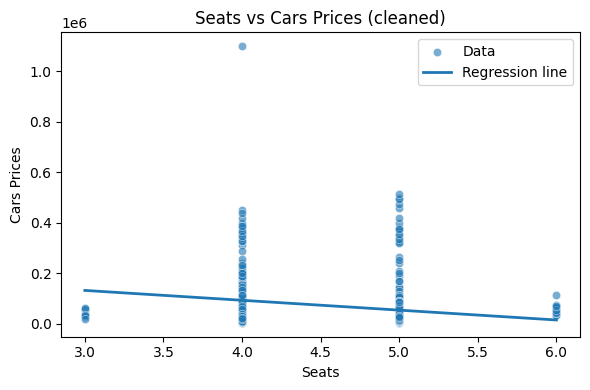

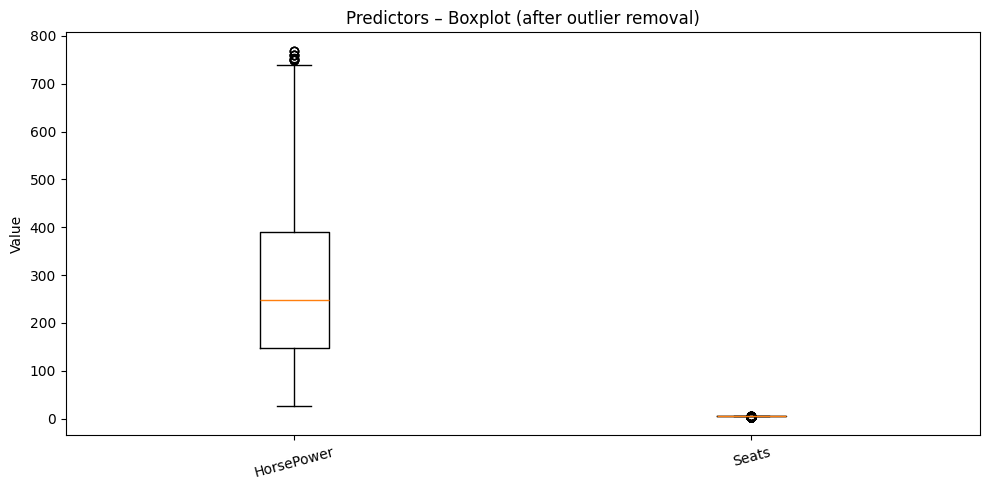

In [147]:
# ===================== FULL ROBUST PIPELINE (with parsing) =====================
# Auto-resolve columns → Parse numerics → Boxplot → Outliers → SLR per predictor
# ==============================================================================

import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ------------ CONFIG ------------
FILE = r"H:\folder\Day_2\CarsDatasets2025.csv"   # <— your file
requested_predictors = ["cc_capacity", "horsepower", "top_speed_kmh",
                        "perf_0_100_s", "seats", "torque_nm"]
requested_target = "price"

USE_IQR = True       # True = IQR (robust for skew); False = Z-score
ZS_THRESHOLD = 3.0   # used only if USE_IQR = False

# ------------ ROBUST READ ------------
def read_csv_robust(path):
    encodings = ["utf-8", "latin1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(
                path,
                encoding=enc,
                engine="python",
                skip_blank_lines=True,
                on_bad_lines="skip",
                quoting=csv.QUOTE_MINIMAL,
                skipinitialspace=True
            )
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv_robust(FILE)

# ------------ HELPERS ------------
def norm_key(s: str) -> str:
    return str(s).strip().lower().replace("-", "_").replace(" ", "").replace("__", "_")

def match_columns_case_insensitive(df: pd.DataFrame, requested_names):
    actual_lookup = {norm_key(col): col for col in df.columns}
    mapping = {}
    for req in requested_names:
        nk = norm_key(req)
        if nk in actual_lookup:
            mapping[req] = actual_lookup[nk]
            continue
        nk2 = nk.replace("_", "")
        hit = None
        for k, original in actual_lookup.items():
            if k.replace("_", "") == nk2:
                hit = original; break
        if hit: mapping[req] = hit
    return mapping

def guess_target_column(df: pd.DataFrame, requested_target: str):
    tmp = match_columns_case_insensitive(df, [requested_target])
    if requested_target in tmp:
        return tmp[requested_target]
    for c in df.columns:
        if "price" in c.lower():
            return c
    raise ValueError(f"Could not find a price-like target. Available columns: {list(df.columns)}")

# Parse messy numerics: removes currency symbols, commas, and unit words
_num_regex = re.compile(r"[-+]?\d*\.?\d+")
def parse_numeric_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")
    # Handle strings like "₹12,34,567.89", "150 bhp", "220 km/h"
    def _to_float(val):
        if pd.isna(val):
            return np.nan
        text = str(val)
        # remove common thousands separators/spaces
        text = text.replace(",", "").replace("₹", "").replace("$", "").replace("€", "").strip()
        # find first numeric pattern
        m = _num_regex.search(text)
        return float(m.group()) if m else np.nan
    return s.map(_to_float)

def ensure_numeric_parsed(df: pd.DataFrame, cols):
    df2 = df.copy()
    for c in cols:
        if c in df2.columns:
            df2[c] = parse_numeric_series(df2[c])
    return df2

def iqr_non_outlier_mask(s: pd.Series):
    x = s.dropna()
    if x.empty: return s.notna()
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return s.between(low, high)

def zscore_non_outlier_mask(s: pd.Series, thr=3.0):
    x = s.astype(float)
    mu = x.mean(skipna=True)
    sigma = x.std(skipna=True, ddof=0)
    if pd.isna(mu) or pd.isna(sigma) or sigma == 0:
        return s.notna()
    z = (x - mu) / sigma
    return z.abs() <= thr

def boxplot_all(df, cols, title="Predictors – Boxplot"):
    data = [pd.to_numeric(df[c], errors="coerce").dropna() for c in cols]
    plt.figure(figsize=(10, 5))
    # Matplotlib ≥3.9 uses tick_labels
    plt.boxplot(data, tick_labels=cols, vert=True, showfliers=True)
    plt.title(title)
    plt.ylabel("Value")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# ------------ RESOLVE COLUMNS ------------
col_map = match_columns_case_insensitive(df, requested_predictors)
predictors = [col_map[n] for n in requested_predictors if n in col_map]
target_col = guess_target_column(df, requested_target)

print("\nResolved columns:")
print("  target:", target_col)
print("  predictors:", predictors)
missing_preds = [n for n in requested_predictors if n not in col_map]
if missing_preds:
    print("  ⚠️ Unresolved predictors (not found):", missing_preds)

# If you only have HorsePower & Seats, that's fine
if not predictors:
    raise SystemExit("No predictors resolved; please check column names in your CSV.")

# ------------ PARSE NUMERICS ------------
# Parse both predictors and target into numeric (handles ₹, commas, units)
df_num = ensure_numeric_parsed(df, predictors + [target_col])

# Quick diagnostics
for c in predictors + [target_col]:
    n_total = len(df_num[c])
    n_num = df_num[c].notna().sum()
    print(f"[Parse] {c}: numeric {n_num}/{n_total} ({n_num/n_total:.1%})")

# ------------ 1) BOX PLOT BEFORE CLEANING ------------
boxplot_all(df_num, predictors, title="Predictors – Boxplot (before outlier removal)")

# ------------ 2) LOOP: Outliers → Remove → Train SLR ------------
for feature in predictors:
    print(f"\n===== Linear Regression: {feature} vs {target_col} =====")

    # (a) slice & drop NaNs
    df_sub = df_num[[feature, target_col]].dropna().copy()
    if df_sub.empty:
        print("No data after parsing & dropping NaNs. Check raw values in these columns.")
        continue

    # (b) detect outliers using chosen method (on feature only)
    if USE_IQR:
        keep_mask = iqr_non_outlier_mask(df_sub[feature])
        method_name = "IQR"
    else:
        keep_mask = zscore_non_outlier_mask(df_sub[feature], thr=ZS_THRESHOLD)
        method_name = f"Z-score (|z| <= {ZS_THRESHOLD})"

    outlier_mask = ~keep_mask
    outliers = df_sub.loc[outlier_mask, feature]

    print(f"Outlier detection method: {method_name}")
    print(f"{feature}: total={len(df_sub)}, outliers={int(outlier_mask.sum())}, kept={int(keep_mask.sum())}")
    if len(outliers) > 0:
        print("Sample outlier values:", outliers.head(min(10, len(outliers))).tolist())

    # (c) remove outliers (for this predictor’s training slice)
    df_clean = df_sub.loc[keep_mask].copy()
    if df_clean.empty:
        print("No data left after outlier removal. Skipping.")
        continue

    X = df_clean[[feature]].to_numpy()
    y = df_clean[target_col].to_numpy()

    # guard: constant predictor after cleaning
    if np.unique(X).size == 1:
        print("Skipped: predictor is constant after outlier removal.")
        continue

    # (d) fit simple linear regression
    lr = LinearRegression().fit(X, y)
    y_pred = lr.predict(X)

    # (e) metrics (version-agnostic RMSE)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f"R²   : {r2:.3f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"Equation: {target_col} = {lr.intercept_:.2f} + {lr.coef_[0]:.2f} * {feature}")

    # (f) scatter + regression line
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X.flatten(), y=y, alpha=0.6, label="Data")
    order = np.argsort(X.flatten())
    plt.plot(X.flatten()[order], y_pred[order], linewidth=2, label="Regression line")
    plt.xlabel(feature); plt.ylabel(target_col)
    plt.title(f"{feature} vs {target_col} (cleaned)")
    plt.legend(); plt.tight_layout(); plt.show()

# ------------ 3) OPTIONAL: BOX PLOT AFTER CLEANING (per-feature) ------------
cleaned_data, labels = [], []
for feature in predictors:
    s = df_num[feature]
    mask = iqr_non_outlier_mask(s) if USE_IQR else zscore_non_outlier_mask(s, thr=ZS_THRESHOLD)
    cleaned_data.append(s[mask].dropna()); labels.append(feature)

plt.figure(figsize=(10, 5))
plt.boxplot(cleaned_data, tick_labels=labels, vert=True, showfliers=True)
plt.title("Predictors – Boxplot (after outlier removal)")
plt.ylabel("Value")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


[Parse] CC/Battery Capacity: numeric 1213/1218 (99.6%)
[Parse] HorsePower: numeric 1218/1218 (100.0%)
[Parse] Total Speed: numeric 1218/1218 (100.0%)
[Parse] Performance(0 - 100 )KM/H: numeric 1212/1218 (99.5%)
[Parse] Seats: numeric 1218/1218 (100.0%)
[Parse] Torque: numeric 1217/1218 (99.9%)
[Parse] Cars Prices: numeric 1217/1218 (99.9%)


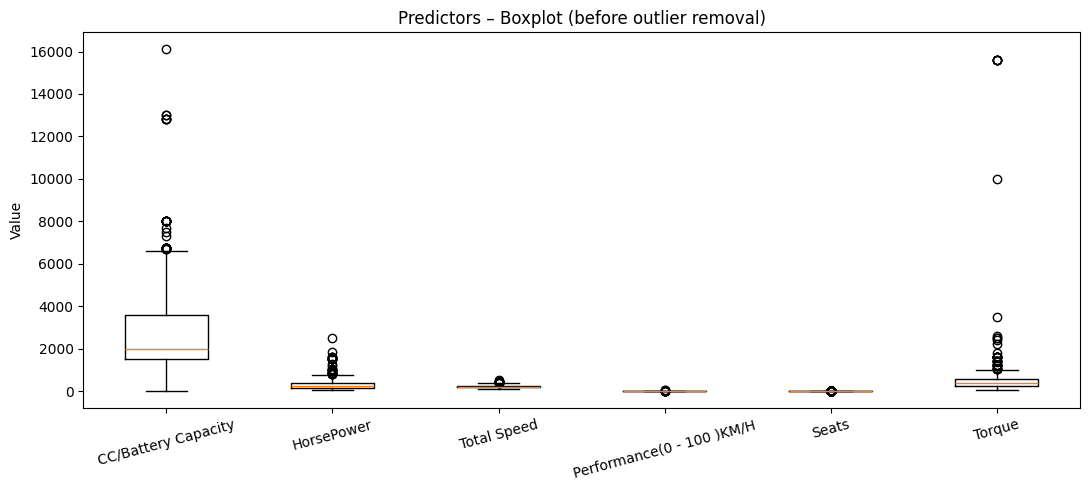


===== Linear Regression: CC/Battery Capacity vs Cars Prices =====
Outlier detection method: IQR
CC/Battery Capacity: total=1213, outliers=38, kept=1175
Sample outlier values: [6749.0, 6749.0, 6749.0, 6749.0, 6749.0, 6749.0, 6749.0, 6749.0, 6749.0, 6749.0]
R²   : 0.074
RMSE : 247684.06
Equation: Cars Prices = -25777.04 + 43.28 * CC/Battery Capacity


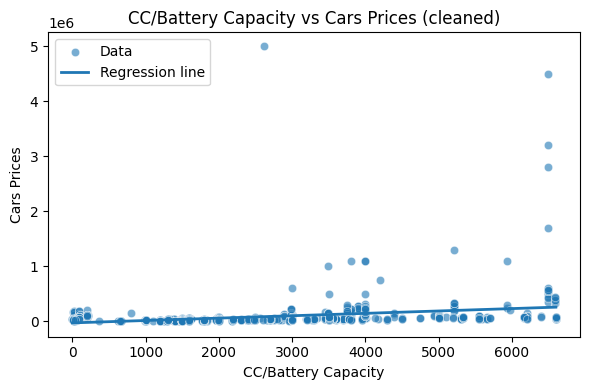


===== Linear Regression: HorsePower vs Cars Prices =====
Outlier detection method: IQR
HorsePower: total=1217, outliers=27, kept=1190
Sample outlier values: [963.0, 789.0, 789.0, 1160.0, 1000.0, 836.0, 819.0, 2488.0, 1020.0, 1020.0]
R²   : 0.176
RMSE : 197259.12
Equation: Cars Prices = -75182.95 + 546.72 * HorsePower


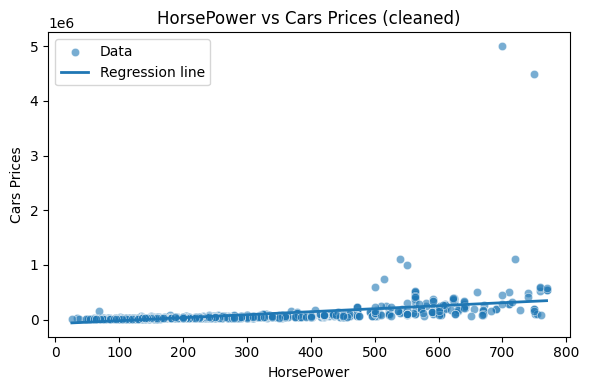


===== Linear Regression: Total Speed vs Cars Prices =====
Outlier detection method: IQR
Total Speed: total=1217, outliers=13, kept=1204
Sample outlier values: [356.0, 402.0, 362.0, 402.0, 420.0, 490.0, 420.0, 420.0, 380.0, 380.0]
R²   : 0.157
RMSE : 204351.42
Equation: Cars Prices = -300895.09 + 1799.81 * Total Speed


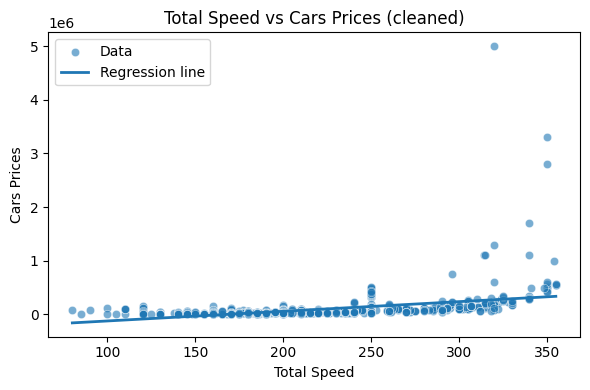


===== Linear Regression: Performance(0 - 100 )KM/H vs Cars Prices =====
Outlier detection method: IQR
Performance(0 - 100 )KM/H: total=1212, outliers=23, kept=1189
Sample outlier values: [23.0, 17.5, 18.0, 18.5, 29.0, 16.0, 16.0, 16.5, 17.0, 17.0]
R²   : 0.050
RMSE : 694626.01
Equation: Cars Prices = 546028.59 + -55390.14 * Performance(0 - 100 )KM/H


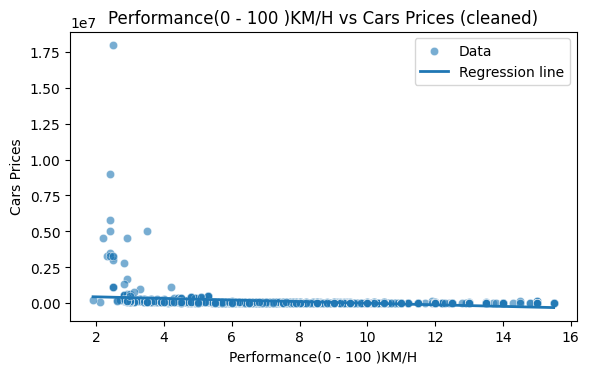


===== Linear Regression: Seats vs Cars Prices =====
Outlier detection method: IQR
Seats: total=1217, outliers=330, kept=887
Sample outlier values: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
R²   : 0.052
RMSE : 80487.89
Equation: Cars Prices = 249731.18 + -39045.72 * Seats


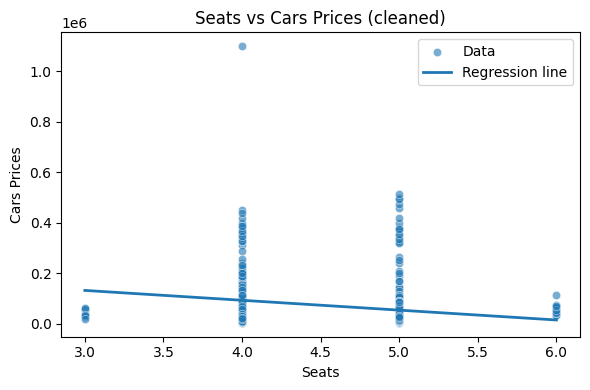


===== Linear Regression: Torque vs Cars Prices =====
Outlier detection method: IQR
Torque: total=1217, outliers=39, kept=1178
Sample outlier values: [1050.0, 1050.0, 1400.0, 1400.0, 1355.0, 10000.0, 1234.0, 1234.0, 1234.0, 1234.0]
R²   : 0.116
RMSE : 244191.42
Equation: Cars Prices = -85153.19 + 432.53 * Torque


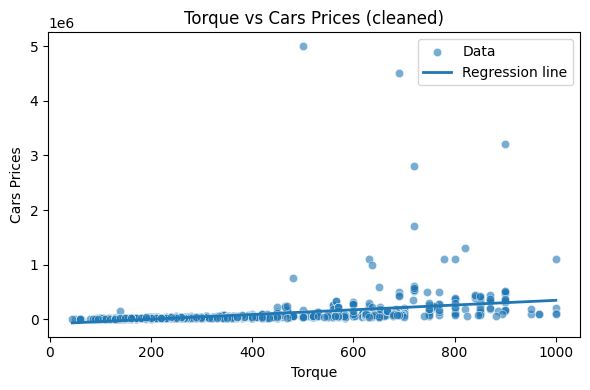

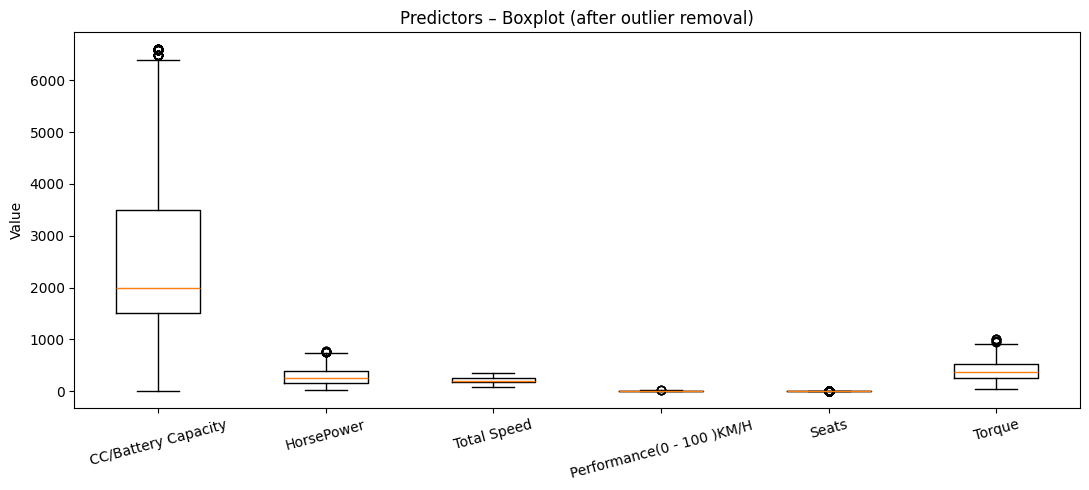

In [148]:
# ===================== Cars Dataset: Boxplots, Outliers, SLR =====================
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ---------- CONFIG ----------
FILE = r"H:\folder\Day_2\CarsDatasets2025.csv"

TARGET = "Cars Prices"
PREDICTORS = [
    "CC/Battery Capacity",      # cc_capacity
    "HorsePower",               # horsepower
    "Total Speed",              # top_speed_kmh
    "Performance(0 - 100 )KM/H",# perf_0_100_s  (if this is time, keep as numeric)
    "Seats",                    # seats
    "Torque"                    # torque_nm
]

USE_IQR = True        # True: IQR rule (robust). False: Z-score rule
ZS_THRESHOLD = 3.0    # if using Z-score

# ---------- LOAD ----------
def read_csv_robust(path):
    encodings = ["utf-8", "latin1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(
                path, encoding=enc, engine="python", skip_blank_lines=True,
                on_bad_lines="skip", quoting=csv.QUOTE_MINIMAL, skipinitialspace=True
            )
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv_robust(FILE)

# ---------- PARSING HELPERS ----------
_num_regex = re.compile(r"[-+]?\d*\.?\d+")

def parse_numeric_series(s: pd.Series) -> pd.Series:
    """Parse messy numerics like '₹12,34,567', '150 bhp', '220 km/h', '1,997 cc', etc."""
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")

    def _to_float(val):
        if pd.isna(val): return np.nan
        text = str(val)
        # common currency/locale chars
        text = (text.replace(",", "")
                    .replace("₹", "")
                    .replace("$", "")
                    .replace("€", "")
                    .replace("km/h", "")
                    .replace("KM/H", "")
                    .replace("kmph", "")
                    .replace("bhp", "")
                    .replace("hp", "")
                    .replace("cc", "")
                    .replace("N·m", "")
                    .replace("Nm", "")
                    .replace("NM", "")
                    .replace("—", "-")
                    .strip())
        m = _num_regex.search(text)
        return float(m.group()) if m else np.nan

    return s.map(_to_float)

def ensure_numeric_parsed(df: pd.DataFrame, cols):
    df2 = df.copy()
    for c in cols:
        if c in df2.columns:
            df2[c] = parse_numeric_series(df2[c])
    return df2

# ---------- OUTLIER MASKS ----------
def iqr_non_outlier_mask(s: pd.Series):
    x = s.dropna()
    if x.empty: return s.notna()
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return s.between(low, high)

def zscore_non_outlier_mask(s: pd.Series, thr=3.0):
    x = s.astype(float)
    mu = x.mean(skipna=True)
    sigma = x.std(skipna=True, ddof=0)
    if pd.isna(mu) or pd.isna(sigma) or sigma == 0:
        return s.notna()
    z = (x - mu) / sigma
    return z.abs() <= thr

# ---------- BOX PLOT ----------
def boxplot_all(df, cols, title="Predictors – Boxplot"):
    data = [pd.to_numeric(df[c], errors="coerce").dropna() for c in cols]
    plt.figure(figsize=(11, 5))
    plt.boxplot(data, tick_labels=cols, vert=True, showfliers=True)  # tick_labels for mpl>=3.9
    plt.title(title)
    plt.ylabel("Value")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# ---------- PREP: numeric parse ----------
use_cols = [c for c in PREDICTORS if c in df.columns] + ([TARGET] if TARGET in df.columns else [])
missing = [c for c in PREDICTORS+[TARGET] if c not in df.columns]
if missing:
    print("⚠️ Missing columns (check spelling):", missing)

df_num = ensure_numeric_parsed(df, use_cols)

# quick diagnostics
for c in use_cols:
    n_total = len(df_num[c])
    n_num = df_num[c].notna().sum()
    print(f"[Parse] {c}: numeric {n_num}/{n_total} ({n_num/n_total:.1%})")

# ---------- 1) BOX PLOT BEFORE CLEANING ----------
boxplot_all(df_num, [c for c in PREDICTORS if c in df_num.columns], title="Predictors – Boxplot (before outlier removal)")

# ---------- 2) LOOP: per-predictor outliers → SLR ----------
for feature in PREDICTORS:
    if feature not in df_num.columns or TARGET not in df_num.columns:
        continue

    print(f"\n===== Linear Regression: {feature} vs {TARGET} =====")

    # slice & drop NaN
    df_sub = df_num[[feature, TARGET]].dropna().copy()
    if df_sub.empty:
        print("No data after parsing & dropping NaNs. Inspect raw values in these columns.")
        continue

    # choose outlier rule on the predictor
    if USE_IQR:
        keep_mask = iqr_non_outlier_mask(df_sub[feature])
        method_name = "IQR"
    else:
        keep_mask = zscore_non_outlier_mask(df_sub[feature], thr=ZS_THRESHOLD)
        method_name = f"Z-score (|z| <= {ZS_THRESHOLD})"

    outlier_mask = ~keep_mask
    outliers = df_sub.loc[outlier_mask, feature]

    print(f"Outlier detection method: {method_name}")
    print(f"{feature}: total={len(df_sub)}, outliers={int(outlier_mask.sum())}, kept={int(keep_mask.sum())}")
    if len(outliers) > 0:
        print("Sample outlier values:", outliers.head(min(10, len(outliers))).tolist())

    # clean training slice
    df_clean = df_sub.loc[keep_mask].copy()
    if df_clean.empty:
        print("No data left after outlier removal. Skipping.")
        continue

    X = df_clean[[feature]].to_numpy()
    y = df_clean[TARGET].to_numpy()

    # guard: constant predictor after cleaning
    if np.unique(X).size == 1:
        print("Skipped: predictor is constant after outlier removal.")
        continue

    # fit SLR
    lr = LinearRegression().fit(X, y)
    y_pred = lr.predict(X)

    # metrics (version-agnostic)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f"R²   : {r2:.3f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"Equation: {TARGET} = {lr.intercept_:.2f} + {lr.coef_[0]:.2f} * {feature}")

    # scatter + regression line
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X.flatten(), y=y, alpha=0.6, label="Data")
    order = np.argsort(X.flatten())
    plt.plot(X.flatten()[order], y_pred[order], linewidth=2, label="Regression line")
    plt.xlabel(feature); plt.ylabel(TARGET)
    plt.title(f"{feature} vs {TARGET} (cleaned)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- 3) OPTIONAL: BOX PLOT AFTER CLEANING (per-feature viz) ----------
cleaned_data, labels = [], []
for feature in PREDICTORS:
    if feature not in df_num.columns: continue
    s = df_num[feature]
    mask = iqr_non_outlier_mask(s) if USE_IQR else zscore_non_outlier_mask(s, thr=ZS_THRESHOLD)
    cleaned_data.append(s[mask].dropna()); labels.append(feature)

if cleaned_data:
    plt.figure(figsize=(11, 5))
    plt.boxplot(cleaned_data, tick_labels=labels, vert=True, showfliers=True)
    plt.title("Predictors – Boxplot (after outlier removal)")
    plt.ylabel("Value")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
